In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'five-crop-diseases-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3771148%2F6523161%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240829%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240829T162016Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D254bc6b9251669d2847d98e632189b2d2137dc7711bd1460e6adc2880cb9ae2df79d8abed6785d372789a2309f62ba0b4ffc5f3cd391bd9944f5f40d129786f47175484278a16deb7025e193ceb02e3d8c08946d82dba041ebb76a316e8ee8412a7efea2b2c65be8ea012e066401d2ff2b6c3a0afb465e43e59a80bc21cbbeae6b0914c248e51b7ac7eae2d179c8162bbee0e1235135a5244e599c37350676777327a08769c95c5a23eb6fae079fad30e9bf5d4836aae7cbb5bc84fecf473f7487213fd2d642bb8cc6a6327f7d606c16ab39a8c77ff2813b633ebb66d6dedfe8ac9927f8ecd27e4b75c1fe23176e68aef91a9019697071b750f9b0b1aa937619'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4651502464 bytes downloaded
Downloaded and uncompressed: five-crop-diseases-dataset
Data source import complete.


### IMPORT DEPENDENCIES

In [72]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### setting Constants

In [73]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

### Directory Path

In [74]:
directory_path = r'/kaggle/input/five-crop-diseases-dataset/Crop Diseases Dataset/Crop Diseases/Crop___Disease/Rice'

### import data into tensorflow

In [75]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    shuffle="True",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 4078 files belonging to 4 classes.


In [76]:
class_names=dataset.class_names
class_names

['Rice___Brown_Spot',
 'Rice___Healthy',
 'Rice___Leaf_Blast',
 'Rice___Neck_Blast']

In [77]:
len(dataset)

128

In [78]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 3 1 0 1 1 2 1 2 1 1 1 1 0 1 0 1 1 1 1 1 1 2 2 2 1 0 3 3 1]


DATA VISUALIZATION

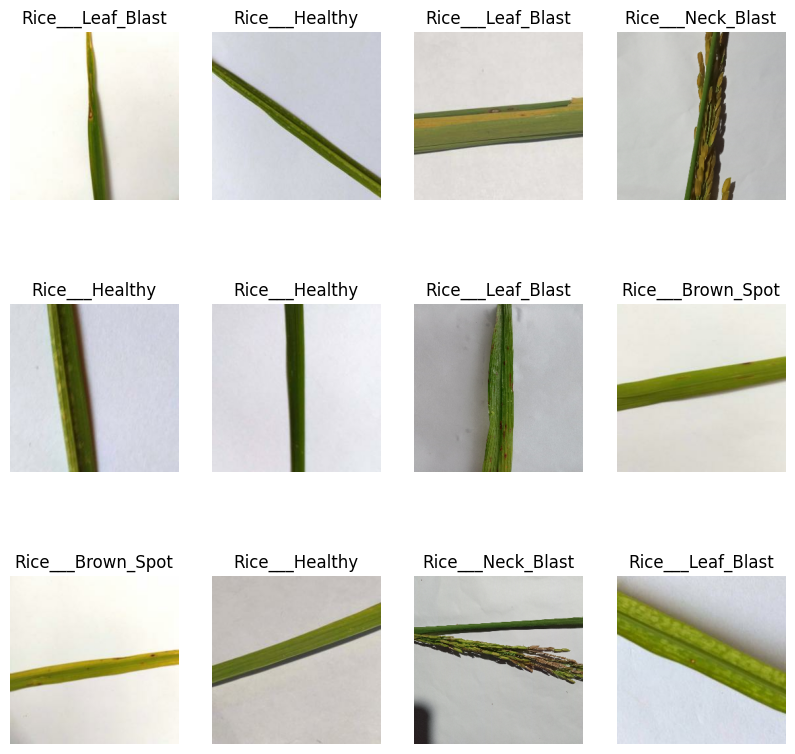

In [79]:
plt.figure(figsize=(10,10))
from numpy import uint16
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
      plt.subplot(3,4,i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])
      plt.axis("off")

**TRAIN TEST SPLIT**

80 % TRAINING

20 % VALIDATION (10% validation + 10% Test)

#### Function to Divide Dataset into train , validation and test

In [80]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(dataset)

    if shuffle:
        daaset = dataset.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [81]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [82]:
len(train_dataset)

102

In [83]:
len(val_dataset)

12

In [84]:
len(test_dataset)

14

### Cache, Shuffle, and Prefetch Dataset

In [85]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# BUILDING MODEL

### RESIZE & RESCALE

In [86]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

### DATA AUGMENTATION

In [87]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

## MODEL ARCHITECTURE

In [88]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [89]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_10 (Sequential)           │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

### Model Complilation

#### We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [90]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [91]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 88s 456ms/step - accuracy: 0.3548 - loss: 1.3416 - val_accuracy: 0.6094 - val_loss: 0.8600
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 64s 67ms/step - accuracy: 0.6064 - loss: 0.8300 - val_accuracy: 0.6328 - val_loss: 0.8084
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.6584 - loss: 0.7544 - val_accuracy: 0.6432 - val_loss: 0.8025
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.6487 - loss: 0.7397 - val_accuracy: 0.6719 - val_loss: 0.8062
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.6743 - loss: 0.7305 - val_accuracy: 0.6901 - val_loss: 0.6602
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7006 - loss: 0.6875 - val_accuracy: 0.7057 - val_loss: 0.6513
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.7104 - loss: 0.6556 - val_accuracy: 0.7344 - val_loss: 0.6324
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.7073 - loss: 0.6726 - val

In [92]:
result = model.evaluate(test_dataset)

14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.8628 - loss: 0.3484


In [93]:
result

[0.368268221616745, 0.8581395149230957]

In [94]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 102}

In [95]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [96]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

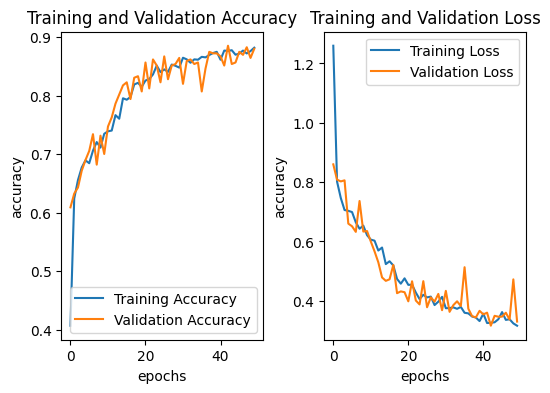

In [97]:
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Training and Validation Loss')
plt.subplots_adjust(wspace=0.3)
plt.show()

## Running Prediction on sample images

In [98]:
import numpy as np
def predict(model, image):
    image_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    image_array = tf.expand_dims(image_array, 0)

    predictions = model.predict(image_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


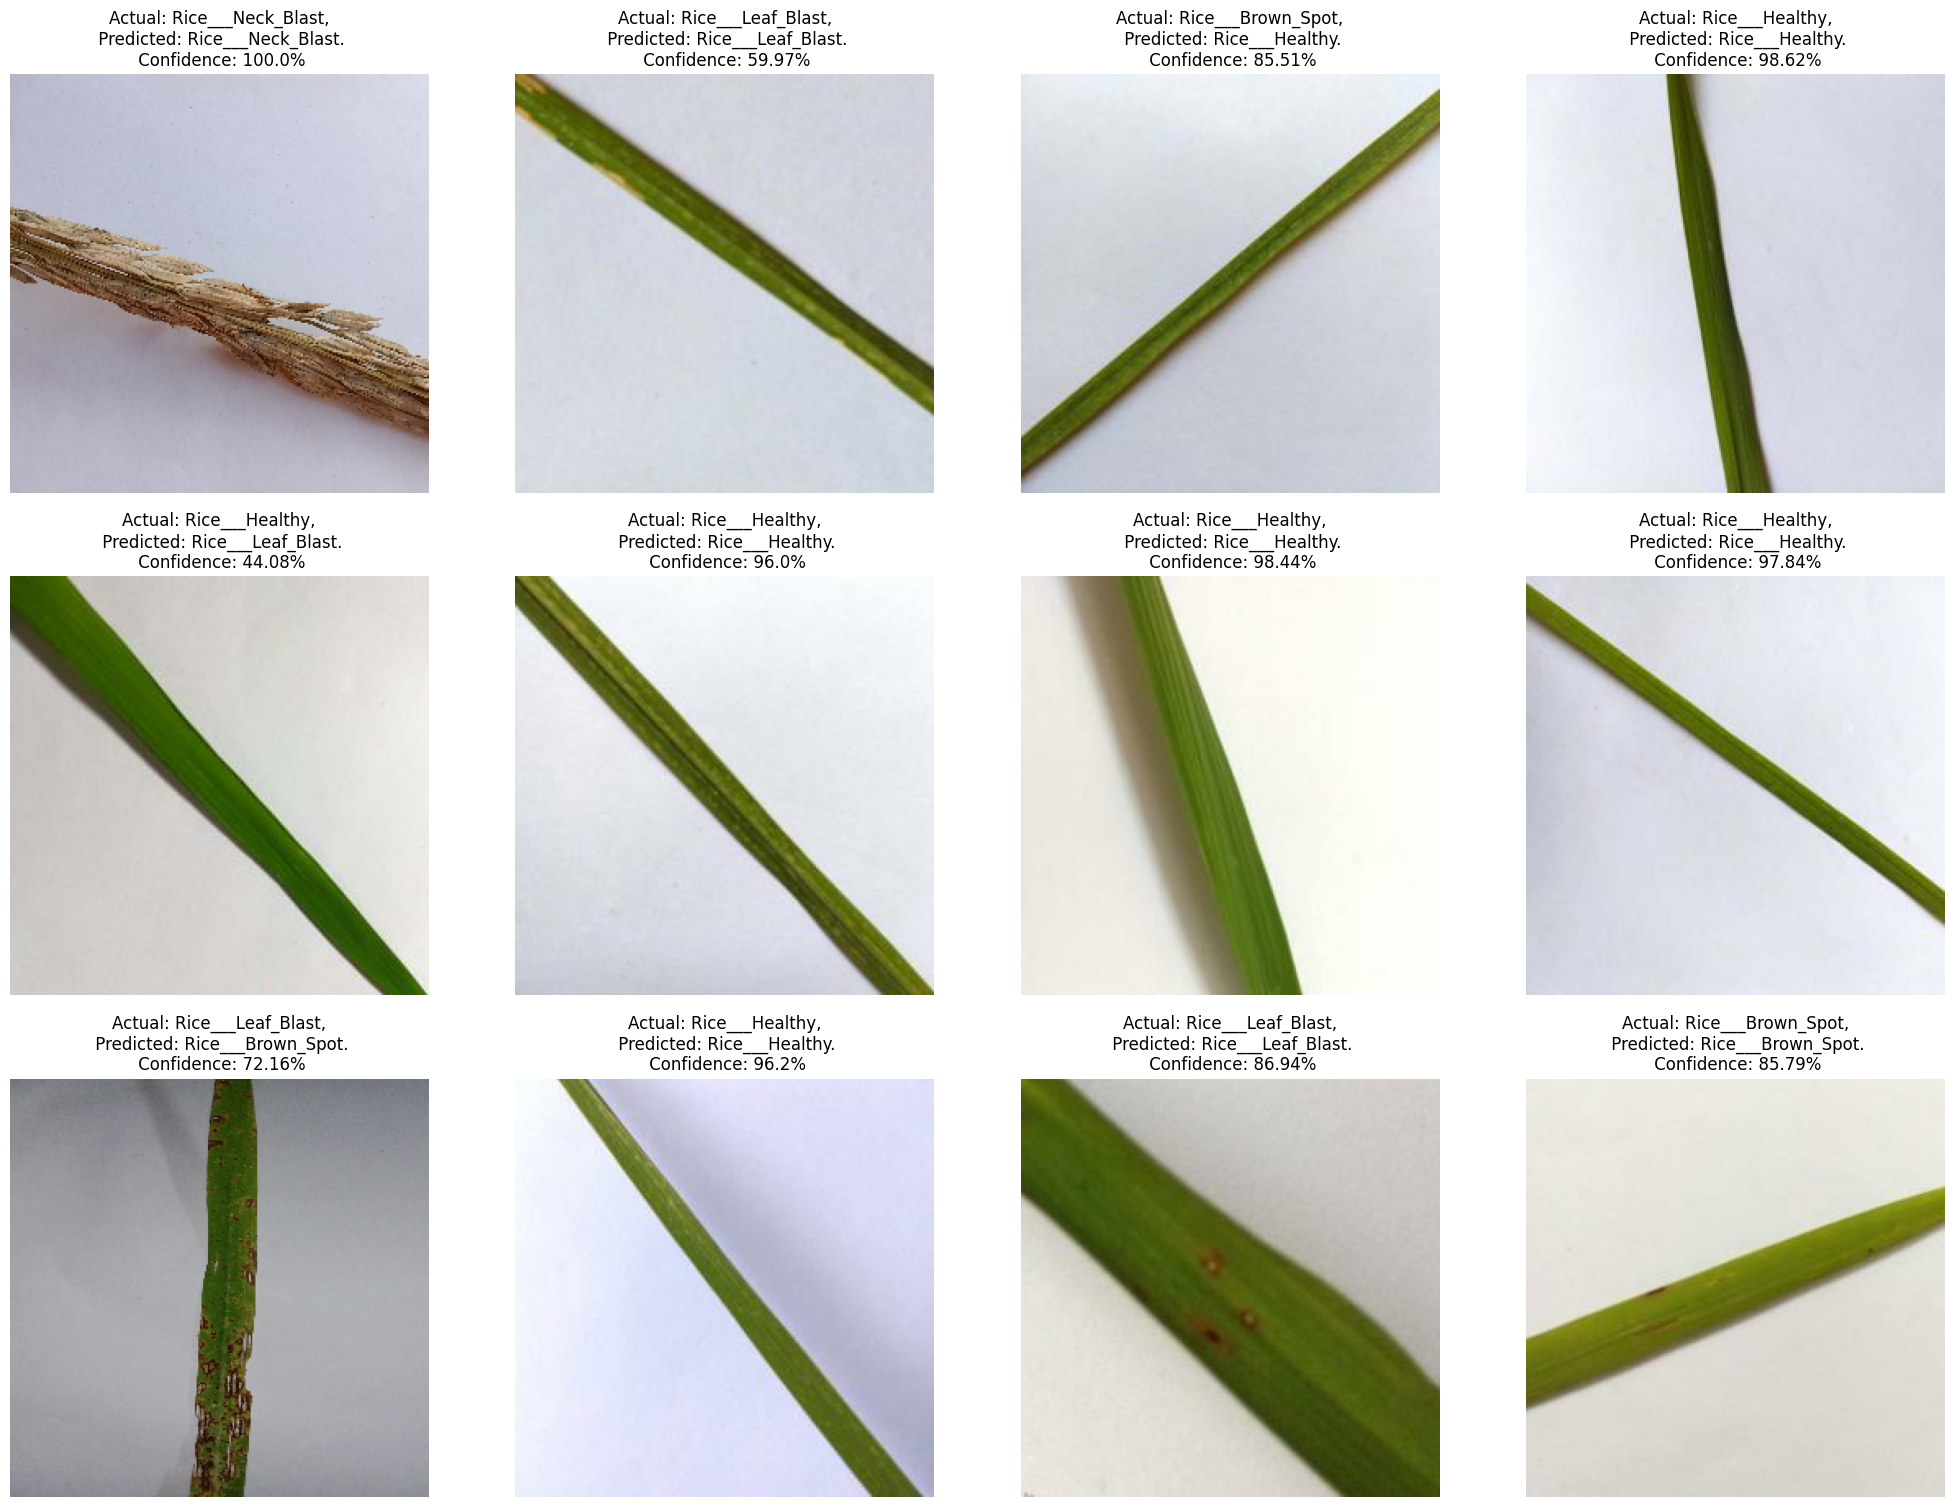

In [99]:
plt.figure(figsize=(25, 25))
for images, labels in test_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [100]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "rice_model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)